In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import functional as F
from sklearn.metrics import accuracy_score
import time
start_time = time.time()

flatten_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=flatten_transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=flatten_transform)

def group_by_class(dataset):
    data_by_class = [[] for _ in range(10)]
    for img, label in dataset:
        data_by_class[label].append(np.array(img))
    
    # Convert inner lists to NumPy arrays
    for i in range(len(data_by_class)):
        data_by_class[i] = np.array(data_by_class[i])
        
    return data_by_class

train_data = group_by_class(train_set)
test_data = group_by_class(test_set)
print("Train data shape: ", np.array(train_data).shape)
print("Test data shape: ", np.array(test_data).shape)


Train data shape:  (10, 6000, 784)
Test data shape:  (10, 1000, 784)


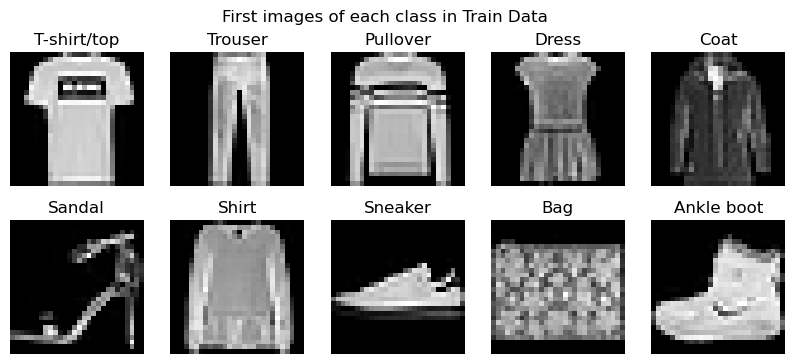

In [38]:
def plot_first_images(data, title):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))  # Change figsize values here
    fig.suptitle(title)

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    for i, class_data in enumerate(data):
        ax = axs[i // 5, i % 5]
        img = class_data[0].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[i])
        ax.axis('off')

    plt.show()

plot_first_images(train_data, 'First images of each class in Train Data')


In [39]:
# Fianl preparation of the dataset
NUM_OF_CLASSES = 10
NUM_OF_SETS = 5

X_train = [_X.T for _X in train_data]  # transpose into (N=896, M=30)

test_sets = []

for test_class in test_data:
    test_sets.extend(np.array_split(test_class, NUM_OF_SETS))

X_test = [_X.T for _X in test_sets]
y_test = []

for i, _ in enumerate(range(NUM_OF_CLASSES)):
    y_test.extend(NUM_OF_SETS * [i])  # add corresponding labels into y_test


In [40]:

# Creating the reference subspace
n_dims = 50
ref_subspaces = [F.rffkmsm(_X, n_dims=n_dims) for _X in X_train]
ref_subspaces = np.array(ref_subspaces)
print(f"Reference subspaces tensor shape: {ref_subspaces.shape}")


# Create the input subpsace
input_subspaces = [F.rffkmsm(set, n_dims=n_dims) for set in X_test]
print(f"Input subspaces shape: {input_subspaces[0].shape}")
print(f"Input subspaces len: {len(input_subspaces)}")

# Calculate the similarities of the input and the reference subspaces
similarities = np.array(
    [
        F.canonical_similarity(ref_subspaces, input_subspace)
        for input_subspace in input_subspaces
    ]
)
predictions = np.argmax(similarities, axis=1)
print(predictions)
print(y_test)


acc = accuracy_score(y_test, predictions)
end_time = time.time()

elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)

print("Time took: {:0>2}:{:05.2f}".format(int(minutes), seconds))
print(f"MSM accuracy: {acc * 100:.2f}")

Reference subspaces tensor shape: (10, 784, 50)
Input subspaces shape: (784, 50)
Input subspaces len: 50
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 2 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9]
Time took: 00:09.52
MSM accuracy: 98.00
